# Exploratory Data Analysis
The borough considered to run the analysis is the arrival borough.
## Exploratory Data Analysis cleaning:
The data that was considered as insignificant for our analysis and the  assumptions that were considered as incorrect are shown below:

- ** "PULoctionID">263 and "DOLocation">263:** These location IDs were categorised as NV, NA and N\A in the datasets.
 
- **fare_amount$\leq$2.5:** It was assumed that to be considered as an actual ride the fare amount must be strictly bigger than the standard initial rate.

-  __trip_distance<0: __Negative distances were considered as incorrect, hence they were removed.

-  **trip_distance=0 and (RatecodeID$\neq$5 or PULocationID=DOLocationID):** Trip distances equal to 0 are only considered as an actual ride when the rate used was the negotiated fare or the location ID of the dropoff and pickup are different. The reason for the former is that it is supposed the fare is agreed beforehand and the taximeter may not be active during the ride. For the latter it is assumed that if the location IDs are different, a ride took place because there was a displacement.

-  **Joining the taxi_lookup_zone.csv with the yellow cabs data for each month:** This step was taken in order to know in which one of the six boroughs(Manhattan,Queens,Brooklyn,Bronx,EWR, Staten Island) each zone is located since our analysis focuses on boroughs instead of the zones.

-  ** Drop unnecessary columns:** The columms with irrelevant information for the analysis.

- **Eliminating data which does not belong to the right database:** It was certified that the month and the year corresponded to the respective database.

- **Adding duration column to the database: ** For reasearch purposes this column was computed in seconds.

-  **Adding miles per hour column and dropping when miles per hour$<$ 2.5:** This column was computed for research purposes and due to the fact that the average speed on traffic in New York is 4.7 mph, cases slower than 2.5 mph were discarded and considered as unplausible.

-  **Drop duration greater than 200 minutes:** After some background verifications rides with longer duration are seen as inconsistent.





In [2]:
import pandas as pd   #libraries 
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from scipy import stats
import seaborn as sns
import json
import folium
import os

plt.style.use('fivethirtyeight')

In [ ]:
key = ['jan_18', 'feb_18', 'mar_18', 'apr_18', 'may_18', 'jun_18']
files = ['yellow_tripdata_2018-01.csv', 'yellow_tripdata_2018-02.csv', 'yellow_tripdata_2018-03.csv', 'yellow_tripdata_2018-04.csv', 'yellow_tripdata_2018-05.csv', 'yellow_tripdata_2018-06.csv']
month = [1,2,3,4,5,6,7,8,9,10,11,12]
#databases with the classification of zones in boroughs
borough=pd.read_csv("taxi _zone_lookup.csv")
for i in range(len(files)): 
    ny = pd.read_csv(files[i])

    ny=ny[(ny["PULocationID"]<=263) &(ny["DOLocationID"]<=263)]
    #remove taxis outside the boroughs. Seen on taxis lookup zones db

    ny=ny[ny["fare_amount"]>2.5]
    #removing all amounts lower or equal to 2.5(standard fare), if fare amount  equal to or less than the standard fare it is assumed the taxi isn't used

    ny=ny[ny["trip_distance"]>=0]#no negative distances
    
    #trip distance with 0 distance but negotiated fares are kept under the assumption, for negotiated fares taxi meters may not be on
    ny=ny[(ny["trip_distance"]>=0) & ((ny["RatecodeID"]==5 )| (ny["PULocationID"]!=ny["DOLocationID"]))]
    
    #join with taxi_look up zone
    ny=ny.join(borough.set_index("LocationID"),on="PULocationID")

    ny=ny.rename(index = str, columns = {"Borough":"PUBorough"})
    
    #drop columns not needed for research question 
    ny=ny.drop(["PULocationID","Zone","service_zone","VendorID","store_and_fwd_flag","fare_amount","extra","mta_tax","tip_amount","tolls_amount","improvement_surcharge","total_amount"],axis=1)

    ny=ny.join(borough.set_index("LocationID"),on="DOLocationID")

    ny=ny.rename(index = str, columns = {"Borough":"DOBorough"})

    ny=ny.drop(["DOLocationID","Zone","service_zone"],axis=1)
    
    ny['tpep_pickup_datetime'] = pd.to_datetime(ny['tpep_pickup_datetime'])
    ny['tpep_dropoff_datetime'] = pd.to_datetime(ny['tpep_dropoff_datetime'])    
    
    #drop data with date-time of a different month or year
    ny = ny[(ny['tpep_dropoff_datetime'].dt.month == month[i]) | (ny['tpep_dropoff_datetime'].dt.year == 2018)]
  
    #calculate the duration in seconds
    ny["duration"] = (ny['tpep_dropoff_datetime'] - ny['tpep_pickup_datetime']).astype('timedelta64[s]')   
    #calculate miles per hour
    ny['miles_hour'] = ny['trip_distance'] / (ny['duration']/3600)
    
    #drop miles per hour of less or equal to 2.5
    ny = ny[ny['miles_hour'] > 2.5]
    
    #drop durations of greater 200 minutes
    ny = ny[ny['duration']/60 < 200]
         
    ny.to_csv(key[i] + '.csv', mode = 'a', header = True)
    del  ny



***[RQ1] In what period of the year Taxis are used more? Create a plot that, for each month, shows the average number of trips recorded each day. Due to the differences among New York zones, we want to visualize the same information for each boroughs.Do you notice any difference among them? Provide comments and plausible explanations about what you observe (e.g.: what is the month with the highest daily average?)* **

In [2]:
jan=pd.read_csv("jan_18.csv") #read files
feb=pd.read_csv("feb_18.csv")
mar=pd.read_csv("mar_18.csv")
apr=pd.read_csv("apr_18.csv")
may=pd.read_csv("may_18.csv")
jun=pd.read_csv("jun_18.csv")
months_list=[jan,feb,mar,apr,may,jun]
boroughs=["Manhattan","Queens","Brooklyn","Bronx","EWR","Staten Island"] #name of the boroughs
month_names=["January","February","March","April","May","June"] #name of the months

In [3]:
mean_month_list=[] 
for month in months_list: 
    #loop to generate list with the mean of number of  trips in all borough for each month
    month["day"]=pd.to_datetime(month["tpep_dropoff_datetime"]).dt.day
    mean_month_list.append(month["day"].value_counts().mean()) #


In [4]:
#EXTRACT FROM THE DATA ALL THE DATA WE NEED
month_lista=[]
i=0
for month in months_list: 
    #loop to get the a nested list with average number of trips per day per month in eachn borough
    month_1=month.loc[:,["day","DOBorough"]]
    month_1["Count"]=""
    borough_lista=[]
    for borough in boroughs:
        aux=pd.DataFrame()
        aux=month_1[month_1["DOBorough"]==borough]
        borough_lista.append(int(aux.groupby(["day","DOBorough"]).count().mean()))
    month_lista.append(borough_lista)
    i+=1

#traspose the nested list with average number of trips per day in each month per borough
borough_lista=list(map(list,zip(*month_lista))) 

del month_1
del jan,feb,mar,apr,may,jun

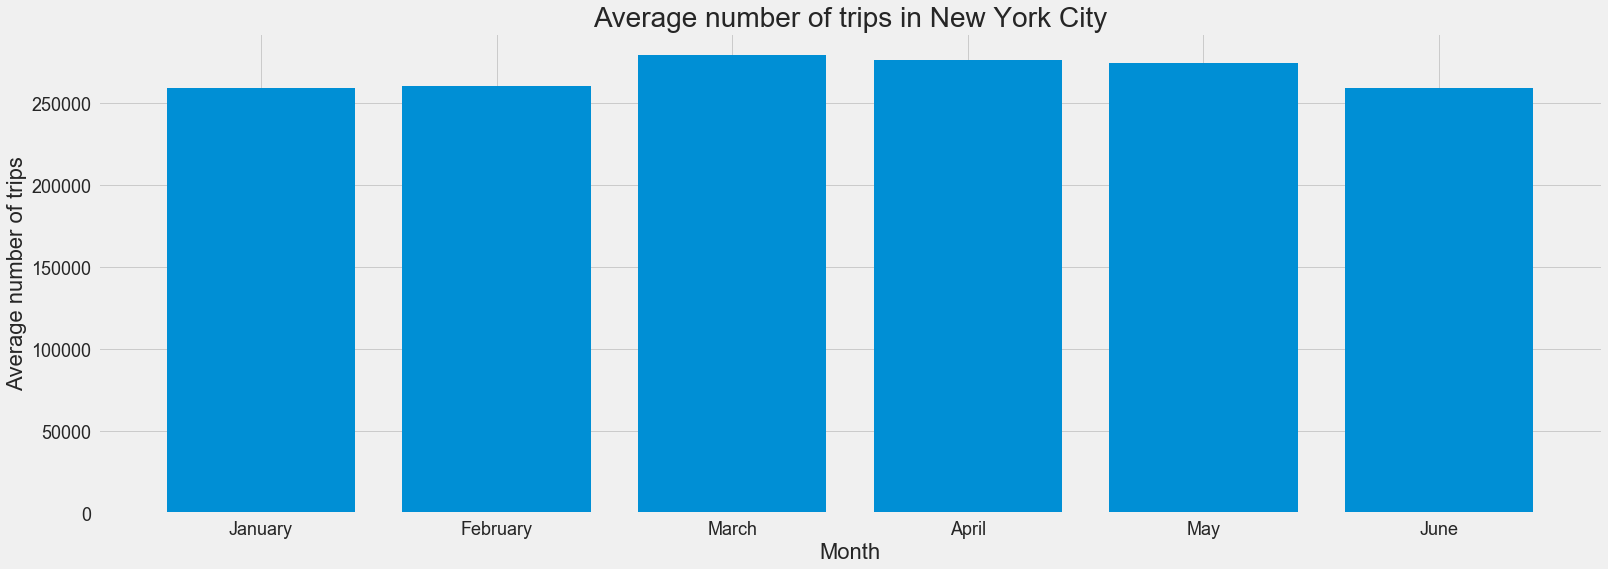

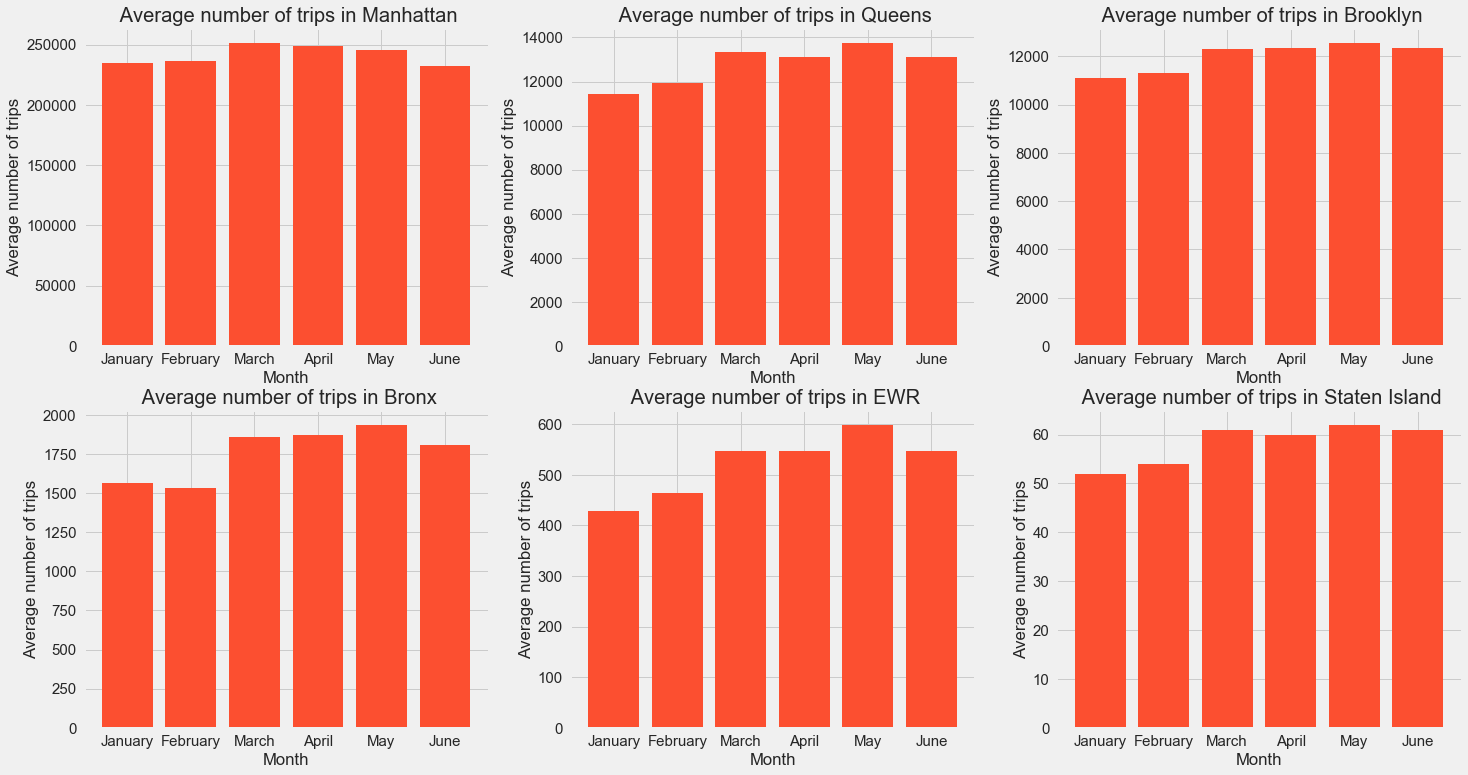

In [12]:
#setting a bar-plot with month against number of trips  in New York City and all the boroughs
y_pos1=np.arange(len(months_list)) 
f = plt.figure(figsize=(24,28))
f.add_subplot(3,1,1)
plt.bar(y_pos1, mean_month_list)
plt.xticks(y_pos1, month_names)
plt.xlabel("Month",fontsize=22)
plt.ylabel("Average number of trips",fontsize=22)
plt.tick_params(labelsize=18)
plt.title("Average number of trips in New York City",fontsize=28)
plt.show()
length=np.arange(6)
width=0.1
#setting a bar-plot with months against number of tripsin all the boroughs
f = plt.figure(figsize=(22,12))
i=1
for i in range(1,6+1):
    f.add_subplot(2,3,i)
    plt.bar(length, borough_lista[i-1], color="#fc4f30")
    plt.xticks(length, month_names)
    plt.tick_params(labelsize=15)
    plt.xlabel("Month")
    plt.ylabel("Average number of trips")
    plt.title(" Average number of trips in "+boroughs[i-1])
    i+=1
plt.show()

- As it can be observed in the plot, the period when taxis are used more are March, April and May, which corresponds to the Spring season.
- In constrast with other boroughs, a clear peak in EWR in May is observed, this might be due to touristic flows. Also, it is time when spring semester finishes in US. There are several universities in New York, two big universities with international approach such as New York University and Columbia university. 
-  Manhattan and Brooklyn have the most constant flow of taxis rides compared with the other boroughs, where it can be observed a bigger difference between Sping and the other seasons.



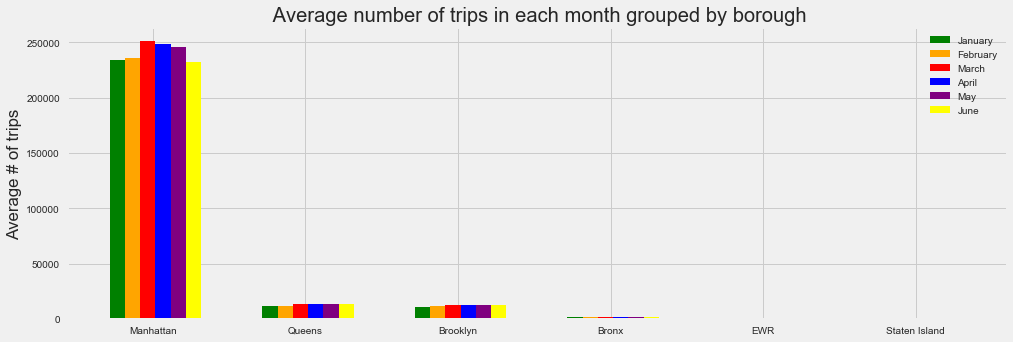

In [13]:
color=["green","orange","red","blue","purple","yellow"]
#setting a bar plot with the number of trips in each borough grouped by months       
f,ax=plt.subplots(figsize=(15,5))
length=np.arange(6)
width=0.1
for i in range(6):
    bar_manhattan=ax.bar(length+(-7+3*i)*width/3, month_lista[i] , width,
                color=color[i], label=month_names[i],fontsize=18)
ax.set_ylabel('Average number of trips')
ax.set_xlabel("Borough")
ax.set_title(' Average number of trips in each month grouped by borough')
ax.set_xticks(length)
ax.set_xticklabels(boroughs)
ax.legend()
plt.show()

-It is observed that the quantity of trips in Manhattan is  much bigger than in the rest of the boroughs. An explanation for this might be that important economical and political spots are located in Manhattan such as Wall Street, UN headquarters and many other points of interest as well as many touristic attractions. 

***[RQ2] What are the time slots with more passengers? Set your own time slots and discover which are those when Taxis drive the highest number of passengers overall New York and repeat the analysis for each borough. Provide the results through a visualization and comment them.***

The length of the time slots considered in this section is two hours. After testing with different intervals lengths, the time slots which shows the significant difference regarding number of passengers is two hours. 

In [14]:
#data for 2018 cleaned for research question
files = ['jan_18.csv', 'feb_18.csv', 'mar_18.csv', 'apr_18.csv','may_18.csv', 'jun_18.csv']

#initialize dictionary for NYC passenger count
dic = {}
#passenger counted in 2 hour interval
interval = 2
#initialize dictionary for each borough
dic_borough = {}
#loop through to read each file
for j in range(len(files)): 
    x = pd.read_csv(files[j])
    
    #get the minute and hour from the pickup time
    x['hours'] = pd.to_datetime(x['tpep_pickup_datetime']).dt.hour    
    x['minutes'] = pd.to_datetime(x['tpep_pickup_datetime']).dt.minute    
    
    #for each interval count the number of passengers
    for i in range(0,int(x['hours'].max())+1,interval):                   
        #values within the time interval
        d = x[((x["hours"]>=i) & (x['minutes'] >= 30) & (x['minutes'] <= 59)) & ((x["hours"]<=i+interval) & (x['minutes'] >= 0) & (x['minutes'] <= 30) )]
        #passenger count for all NYC
        y = d['passenger_count'].values
        #passenger count for each borough
        m = d[d['DOBorough'] == 'Manhattan']['passenger_count'].values
        b = d[d['DOBorough'] == 'Brooklyn']['passenger_count'].values
        br = d[d['DOBorough'] == 'Bronx']['passenger_count'].values
        q = d[d['DOBorough'] == 'Queens']['passenger_count'].values
        e = d[d['DOBorough'] == 'EWR']['passenger_count'].values
        s = d[d['DOBorough'] == 'Staten Island']['passenger_count'].values
        #sum the passenger count and assign to the respective variable
        try: 
            dic[i] += sum(y)            
            dic_borough['manhattan'][i] = sum(m)
            dic_borough['brooklyn'][i] = sum(b)
            dic_borough['bronx'][i] = sum(br)
            dic_borough['queens'][i]= sum(q)
            dic_borough['ewr'][i] = sum(e)
            dic_borough['staten island'][i] = sum(s)
        except: 
            dic[i] = sum(y)
            dic_borough.setdefault('manhattan', {})[i] = sum(m)
            dic_borough.setdefault('brooklyn', {})[i] = sum(b)
            dic_borough.setdefault('bronx', {})[i] = sum(br)
            dic_borough.setdefault('queens', {})[i] = sum(q)
            dic_borough.setdefault('ewr', {})[i] = sum(e)
            dic_borough.setdefault('staten island', {})[i] = sum(s)
            
            

In [15]:
#set up values for graph

x_values = []
y_values = []
manhattan = []
brooklyn = []
bronx = []
queens = []
ewr = []
staten_island = []
for key in dic: 
    v = key + interval
    if(v == 24): 
        v = 0
    x_values.append(str(key) + ':30 -' + str(v) + ':30')
    y_values.append(dic[key])
    
    manhattan.append(dic_borough['manhattan'][key])
    brooklyn.append(dic_borough['brooklyn'][key])
    bronx.append(dic_borough['bronx'][key])
    queens.append(dic_borough['queens'][key])
    ewr.append(dic_borough['ewr'][key])
    staten_island.append(dic_borough['staten island'][key])

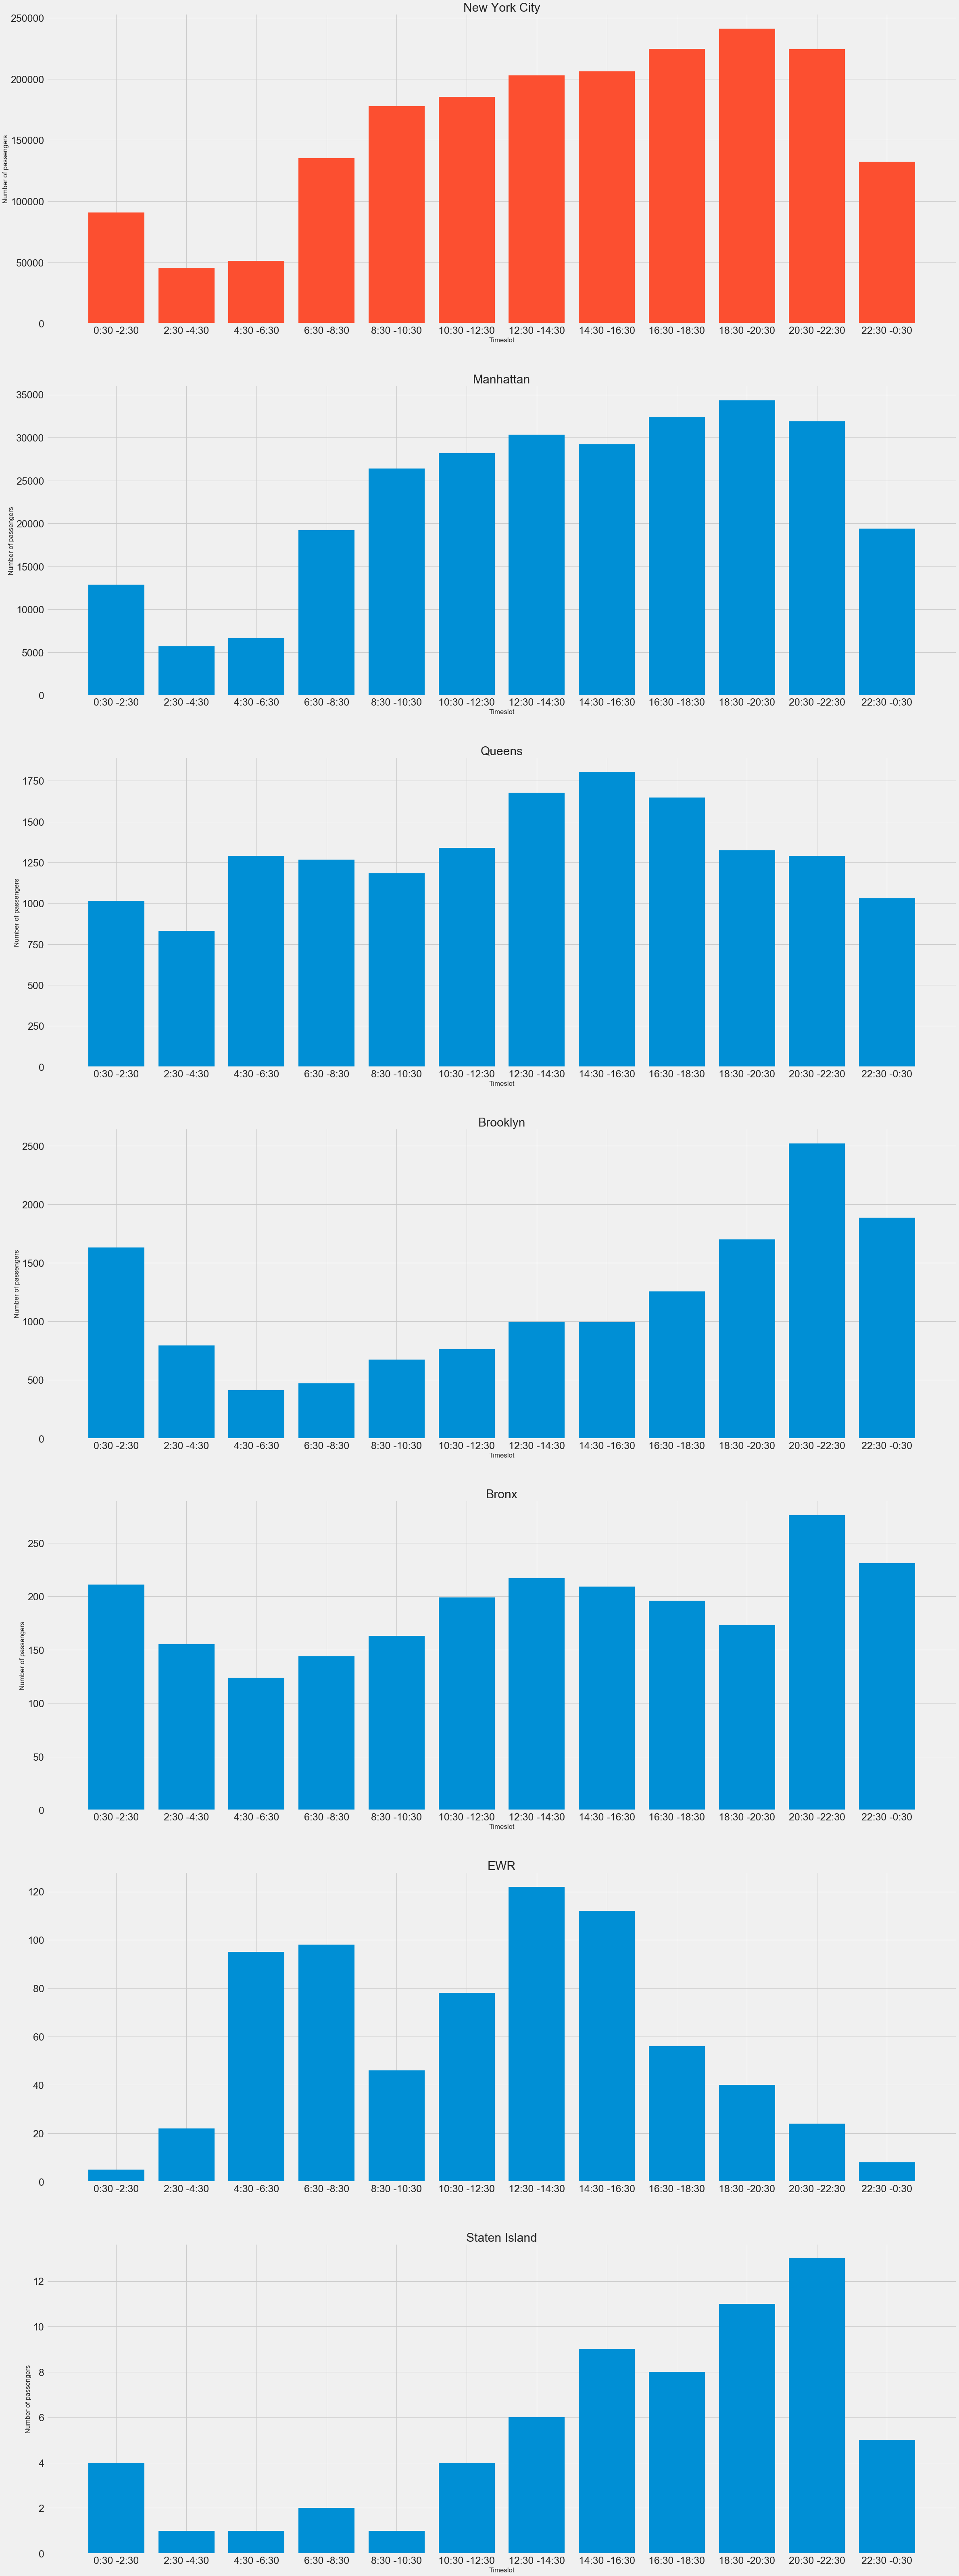

In [17]:
f=plt.figure(figsize =(36,108))
f.add_subplot(7,1,1)
length = np.arange(len(x_values))

plt.bar(length,y_values,color="#fc4f30")
plt.xticks(length, x_values)
plt.tick_params(labelsize=25)
plt.title('New York City', fontsize=40)
plt.xlabel('Timeslot', fontsize = 20)
plt.ylabel('Number of passengers', fontsize = 20)
f.add_subplot(7,1,2)

plt.bar(length,manhattan)
plt.xticks(length, x_values)
plt.tick_params(labelsize=25)
plt.title('Manhattan',fontsize=40)
plt.xlabel('Timeslot', fontsize = 20)
plt.ylabel('Number of passengers', fontsize = 20)
f.add_subplot(7,1,4)

plt.tick_params(labelsize=25)
plt.bar(length,brooklyn)
plt.title('Brooklyn',fontsize=40)
plt.xlabel('Timeslot', fontsize = 20)
plt.ylabel('Number of passengers', fontsize = 20)
plt.xticks(length, x_values)
plt.tick_params(labelsize=25)
f.add_subplot(7,1,5)

plt.bar(length,bronx)
plt.xticks(length, x_values)
plt.tick_params(labelsize=25)
plt.title('Bronx',fontsize=40)
plt.xlabel('Timeslot', fontsize = 20)
plt.ylabel('Number of passengers', fontsize = 20)
f.add_subplot(7,1,3)
plt.bar(length,queens)
plt.xticks(length, x_values)
plt.tick_params(labelsize=25)
plt.title('Queens',fontsize=40)
plt.xlabel('Timeslot', fontsize = 20)
plt.ylabel('Number of passengers', fontsize = 20)
f.add_subplot(7,1,6)

plt.bar(length,ewr)
plt.xticks(length, x_values)
plt.tick_params(labelsize=25)
plt.title('EWR',fontsize=40)
plt.xlabel('Timeslot', fontsize = 20)
plt.ylabel('Number of passengers', fontsize = 20)
f.add_subplot(7,1,7)

plt.bar(length,staten_island)
plt.xticks(length, x_values)
plt.tick_params(labelsize=25)
plt.title('Staten Island',fontsize=40)
plt.xlabel('Timeslot', fontsize = 20)
plt.ylabel('Number of passengers', fontsize = 20)
plt.show()


  

-  The interval with more passengers for all New York City is from 16:30 to 22:30, the peak being from 18:30 to 20:30. This might be explained due to the fact of the evening rush hour, which runs from 16:00 to 20:00, apart from the social activities that might last up to 23:00. 
-  The timeslots with a bigger number of passengers in Manhattan is similar to NYC: from 16:30 to 22:30. This corresponds to the fact that Manhattan is the borough with the bigger amount of taxi rides in NYC as also seen in the previous question. 
-  The timeslot with the highest passenger in Brooklyn is from 20:30 to 22:30. The interval between 22:30 and 2:30 has a relatively high passenger count. A possible explanation of this may be  most residents in Brooklyn commute to another borough for work, therefore, the peaks may be people getting back to their home.
- Bronx has a low passenger count relative to Manhattan and Brooklyn. This may be due to, as we discovered after some research, most residents of Bronx use public transportation. The interval from 20:30 to 22:30 has the highest peak which corresponds to evening rush hour. 
- The timeslots with high passenger count are those between 12:30 to 18:30, where the peak is from 14:30 to 16:30. As Queens is home to JFK International Airport and LaGuardia Airport, which are among the world's busiest, the peaks might happen when a bigger number of flights are departing from both airports in that time interval.
-  The highest passenger count is between 4:30 to 6:30 and between 12:30 to 16:30, the peak being from 12:30 to 14:30. As EWR  is home to Newark airport, the peaks might happen when a bigger number of flights are departing from the airport.
- Staten Isalnd has the lowest passenger count in all of NYC. Staten Island has the highest passenger count between 18:30 to 22:30, the peak being between 20:30 to 22:30, which correspnds to evening rush hour.

***[RQ3] Do the all trips last the same? Let's put our attention on the distribution of trip's duration. Provide a plot for it and comment what you see. Run this analysis for NYC and for each borough (and obviously comment the results!).***

In [18]:
durations = []
durations_by_borough={}

#loop through to read files
for j in range(len(files)): 
    x = pd.read_csv(files[j])
    
    #taxi trip durations in hours for NYC
    durations.append(list(map(float,(x['duration']/3600).values)))
    
    #taxi trip durations for manhattan in hours
    durations_by_borough['Manhattan'] = x[(x['DOBorough'] == 'Manhattan')]['duration']/3600
    #taxi trip durations for bronx in hours
    durations_by_borough['Bronx'] = x[(x['DOBorough'] == 'Bronx')]['duration']/3600
    #taxi trip durations for brooklyn in hours
    durations_by_borough['Brooklyn'] = x[(x['DOBorough'] == 'Brooklyn')]['duration']/3600
    #taxi trip durations for staten island in hours
    durations_by_borough['Staten Island'] = x[(x['DOBorough'] == 'Staten Island')]['duration']/3600
    #taxi trip durations for ewr in hours
    durations_by_borough['EWR'] = x[(x['DOBorough'] == 'EWR')]['duration']/3600
    #taxi trip durations for queens in hours
    durations_by_borough['Queens'] = x[(x['DOBorough'] == 'Queens')]['duration']/3600    
    del x
durations=list(chain(*durations))

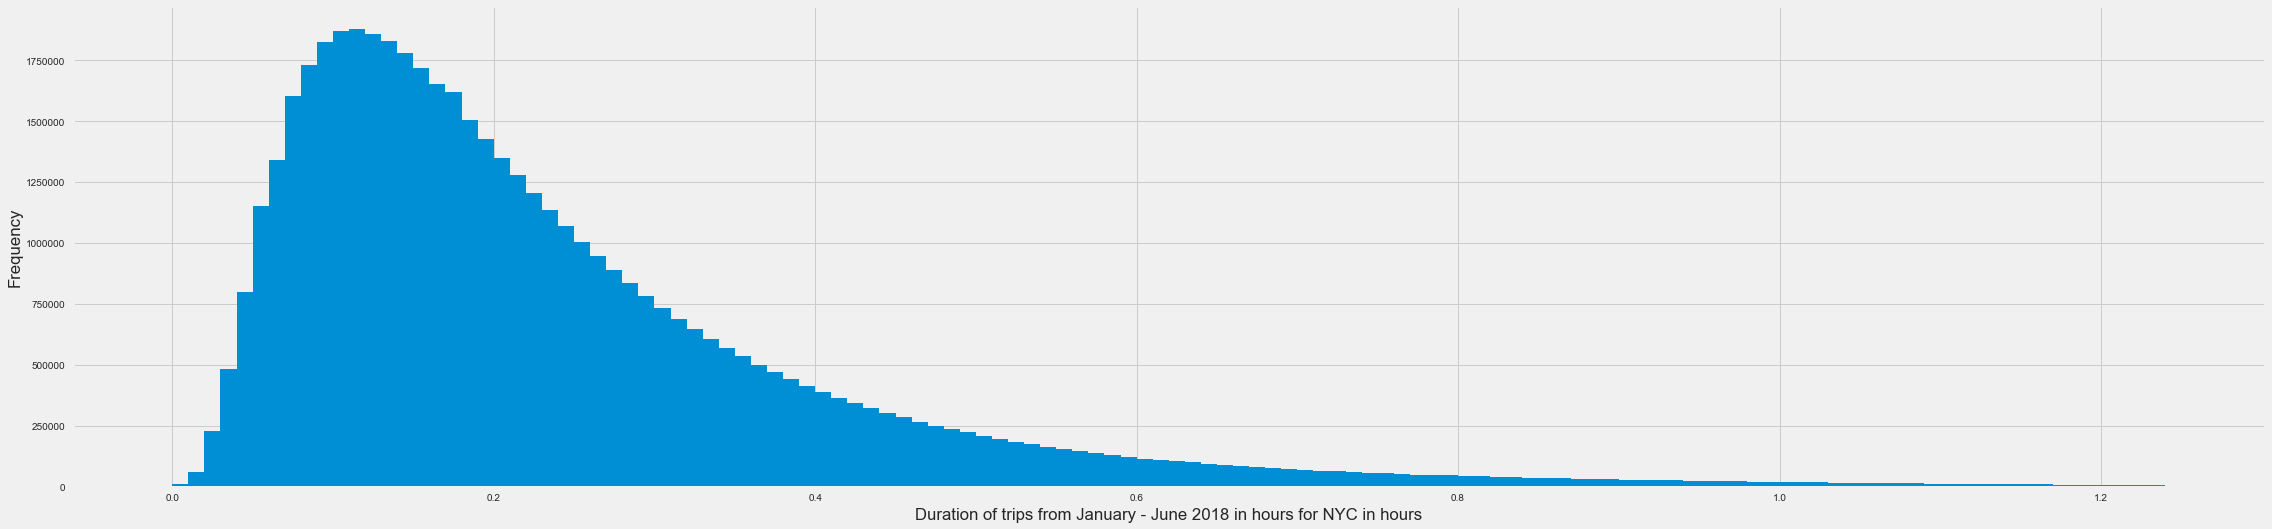

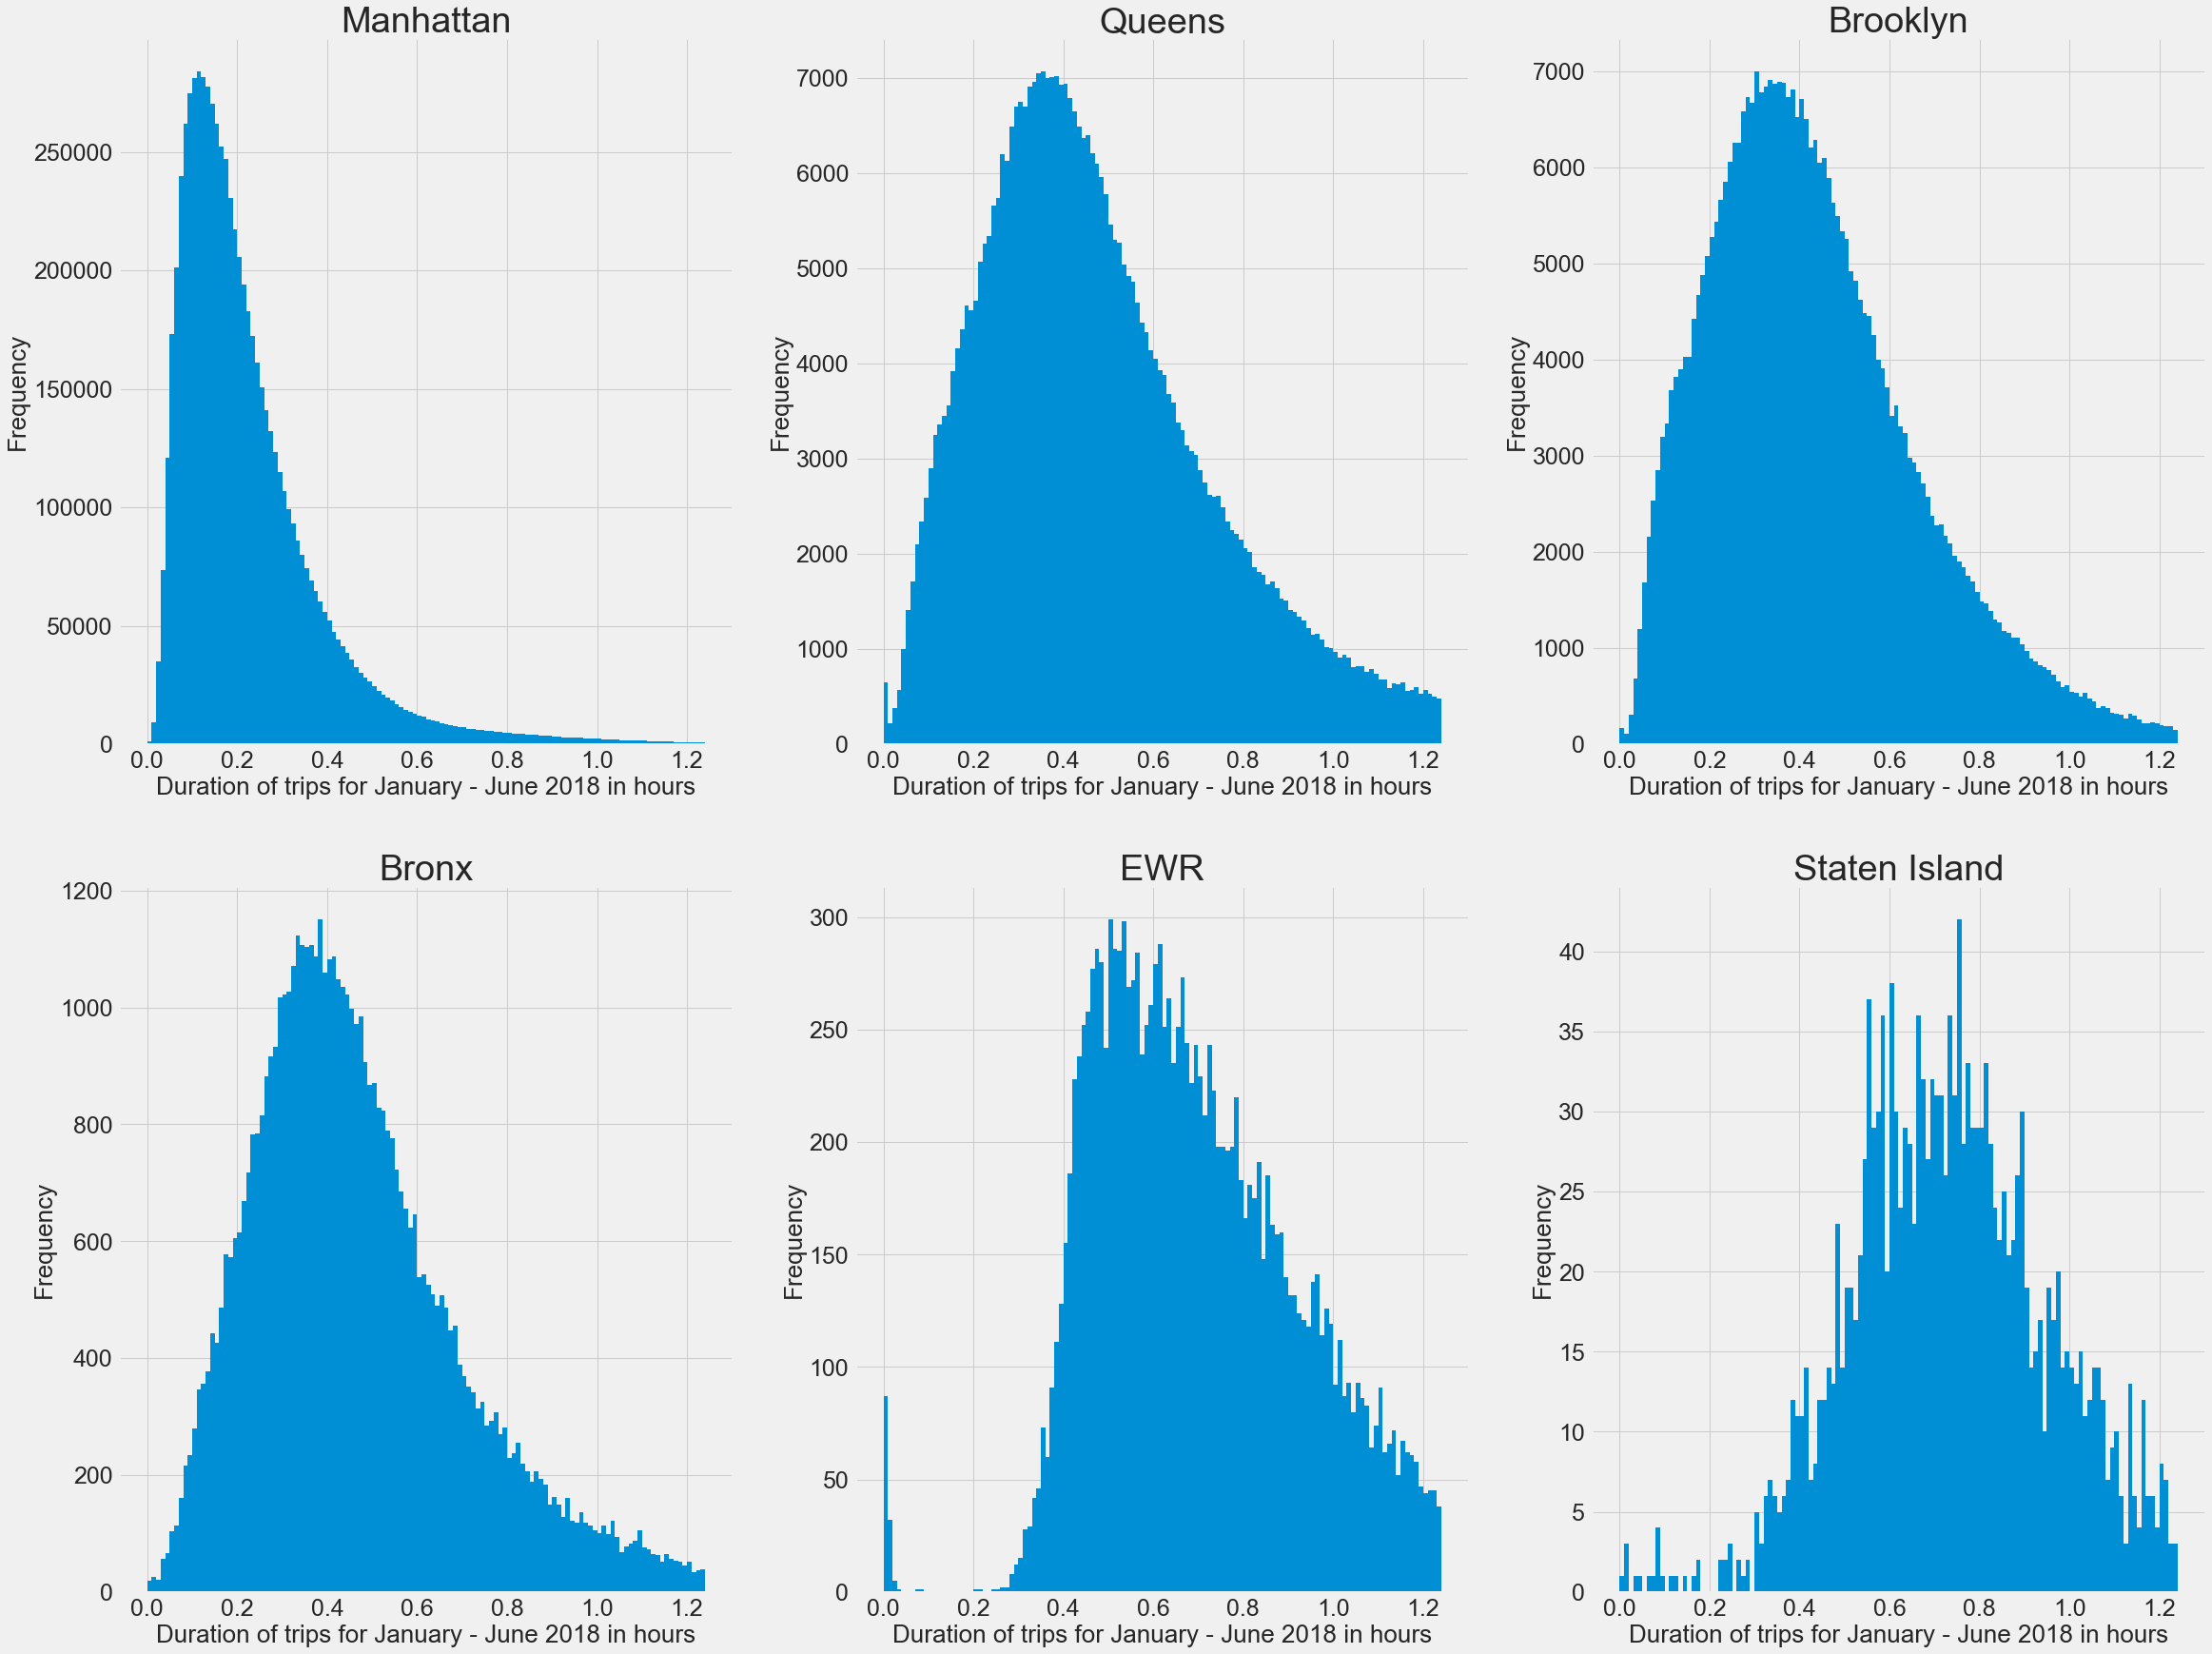

In [19]:
#plot a distribution for the entire data
f=plt.figure(figsize =(35,28))
f.add_subplot(3,1,1)

#set up bins for the histogram
bins = []
i = 0
while(i <= 1.25): 
    bins.append(i)
    i += 0.01
plt.hist(durations,bins)
plt.tick_params(labelsize=25)
plt.xlabel('Duration of trips from January - June 2018 in hours for NYC in hours', fontsize = 26)
plt.ylabel('Frequency', fontsize = 26)
plt.title('NYC', fontsize = 38)
plt.show()
#trips with duration of about an for manhattan
f=plt.figure(figsize =(35,28))
f.add_subplot(2,3,1)
plt.hist(durations_by_borough['Manhattan'], bins)
plt.xlabel('Duration of trips for January - June 2018 in hours',fontsize=26)
plt.ylabel('Frequency',fontsize=26)
plt.tick_params(labelsize=25)
plt.title("Manhattan",fontsize=38)
#trips with duration of about an for brooklyn
f.add_subplot(2,3,3)
plt.hist(durations_by_borough['Brooklyn'],bins)
plt.xlabel('Duration of trips for January - June 2018 in hours',fontsize=26)
plt.ylabel('Frequency',fontsize=26)
plt.tick_params(labelsize=25)
plt.title("Brooklyn",fontsize=38)
#trips with duration of about an for bronx
f.add_subplot(2,3,4)
plt.hist(durations_by_borough['Bronx'],bins)
plt.xlabel('Duration of trips for January - June 2018 in hours',fontsize=26)
plt.ylabel('Frequency',fontsize=26)
plt.tick_params(labelsize=25)
plt.title("Bronx",fontsize=38)
f.add_subplot(2,3,2)
plt.hist(durations_by_borough['Queens'],bins)
plt.xlabel('Duration of trips for January - June 2018 in hours',fontsize=26)
plt.ylabel('Frequency',fontsize=26)
plt.tick_params(labelsize=25)
plt.title("Queens",fontsize=38)
f.add_subplot(2,3,5)
plt.hist(durations_by_borough['EWR'],bins)
plt.xlabel('Duration of trips for January - June 2018 in hours',fontsize=26)
plt.ylabel('Frequency',fontsize=26)
plt.tick_params(labelsize=25)
plt.title("EWR",fontsize=38)
f.add_subplot(2,3,6)
plt.hist(durations_by_borough['Staten Island'],bins)
plt.xlabel('Duration of trips for January - June 2018 in hours',fontsize=26)
plt.ylabel('Frequency',fontsize=26)
plt.tick_params(labelsize=25)
plt.title("Staten Island",fontsize=38)
plt.show()

As it can be seen from the graph, all trips do not last the same. Most trips last from 3 minutes to 15 minutes.

-  For all range of taxi trip duration, Manhattan has the highest frequency. The trip duration in Brooklyn, Bronx and Queens are similar. The trip duration in EWR and Staten Island take longer as these boroughs are far away from the other boroughs, therefore commutes take longer.

-  The trip duration in Manhattan frequently last between 3 minutes to 15 minutes. This may be due to Manhattan being an active borough and most location of interest may be closer to each other.

-  The frequent trip duration in Brooklyn is between 20 minutes to 40 minutes.

-  The frequent trip duration in Bronx is between 25 minutes to 40 minutes.

-  The frequent trip duration in Queens is between 20 minutes and 40 minutes.

-  The frequent trip duration in EWR is between 30 minutes and 60 minutes.

-  The frequent trip duration in Staten Island are between 40 minutes to 60 minutes.


***[RQ4] What is the most common way of payments? Discover the way payments are executed in each borough and visualize the number of payments for any possible means. Then run the Chi-squared test to see whether the method of payment is correlated to the borough. Then, comment the results.***

In [3]:
month_frame=[]
month_list_18=["jan_18","feb_18","mar_18","apr_18","may_18","jun_18"]
for file in month_list_18: 
    #loop over each file and extract the informaation needed for the task
    month = pd.read_csv(file+".csv")  
    month_frame.append(month[["DOBorough","payment_type"]])#list with each dataframe
    del month 
df=pd.concat(month_frame)#concatenate all the information for each month 
del month_frame


In [4]:
#counting payment type number for in New York(all borogh)
ny_payment_type=list((df.groupby(["payment_type"]).count())["DOBorough"])
payment_types=list(df["payment_type"].unique())
payment_types.sort()


In [5]:
borough_lista=[]
df["Count"]=""
boroughs=["Manhattan","Queens","Brooklyn","Bronx","EWR","Staten Island"]
for borough in boroughs:
    #loop to get a nested list with payment type in each borough in all months
        aux=pd.DataFrame()
        aux=df[df["DOBorough"]==borough]
        borough_lista.append(list(map(int,((df[df["DOBorough"]==borough]).groupby(["payment_type","DOBorough"]).count()).values)))


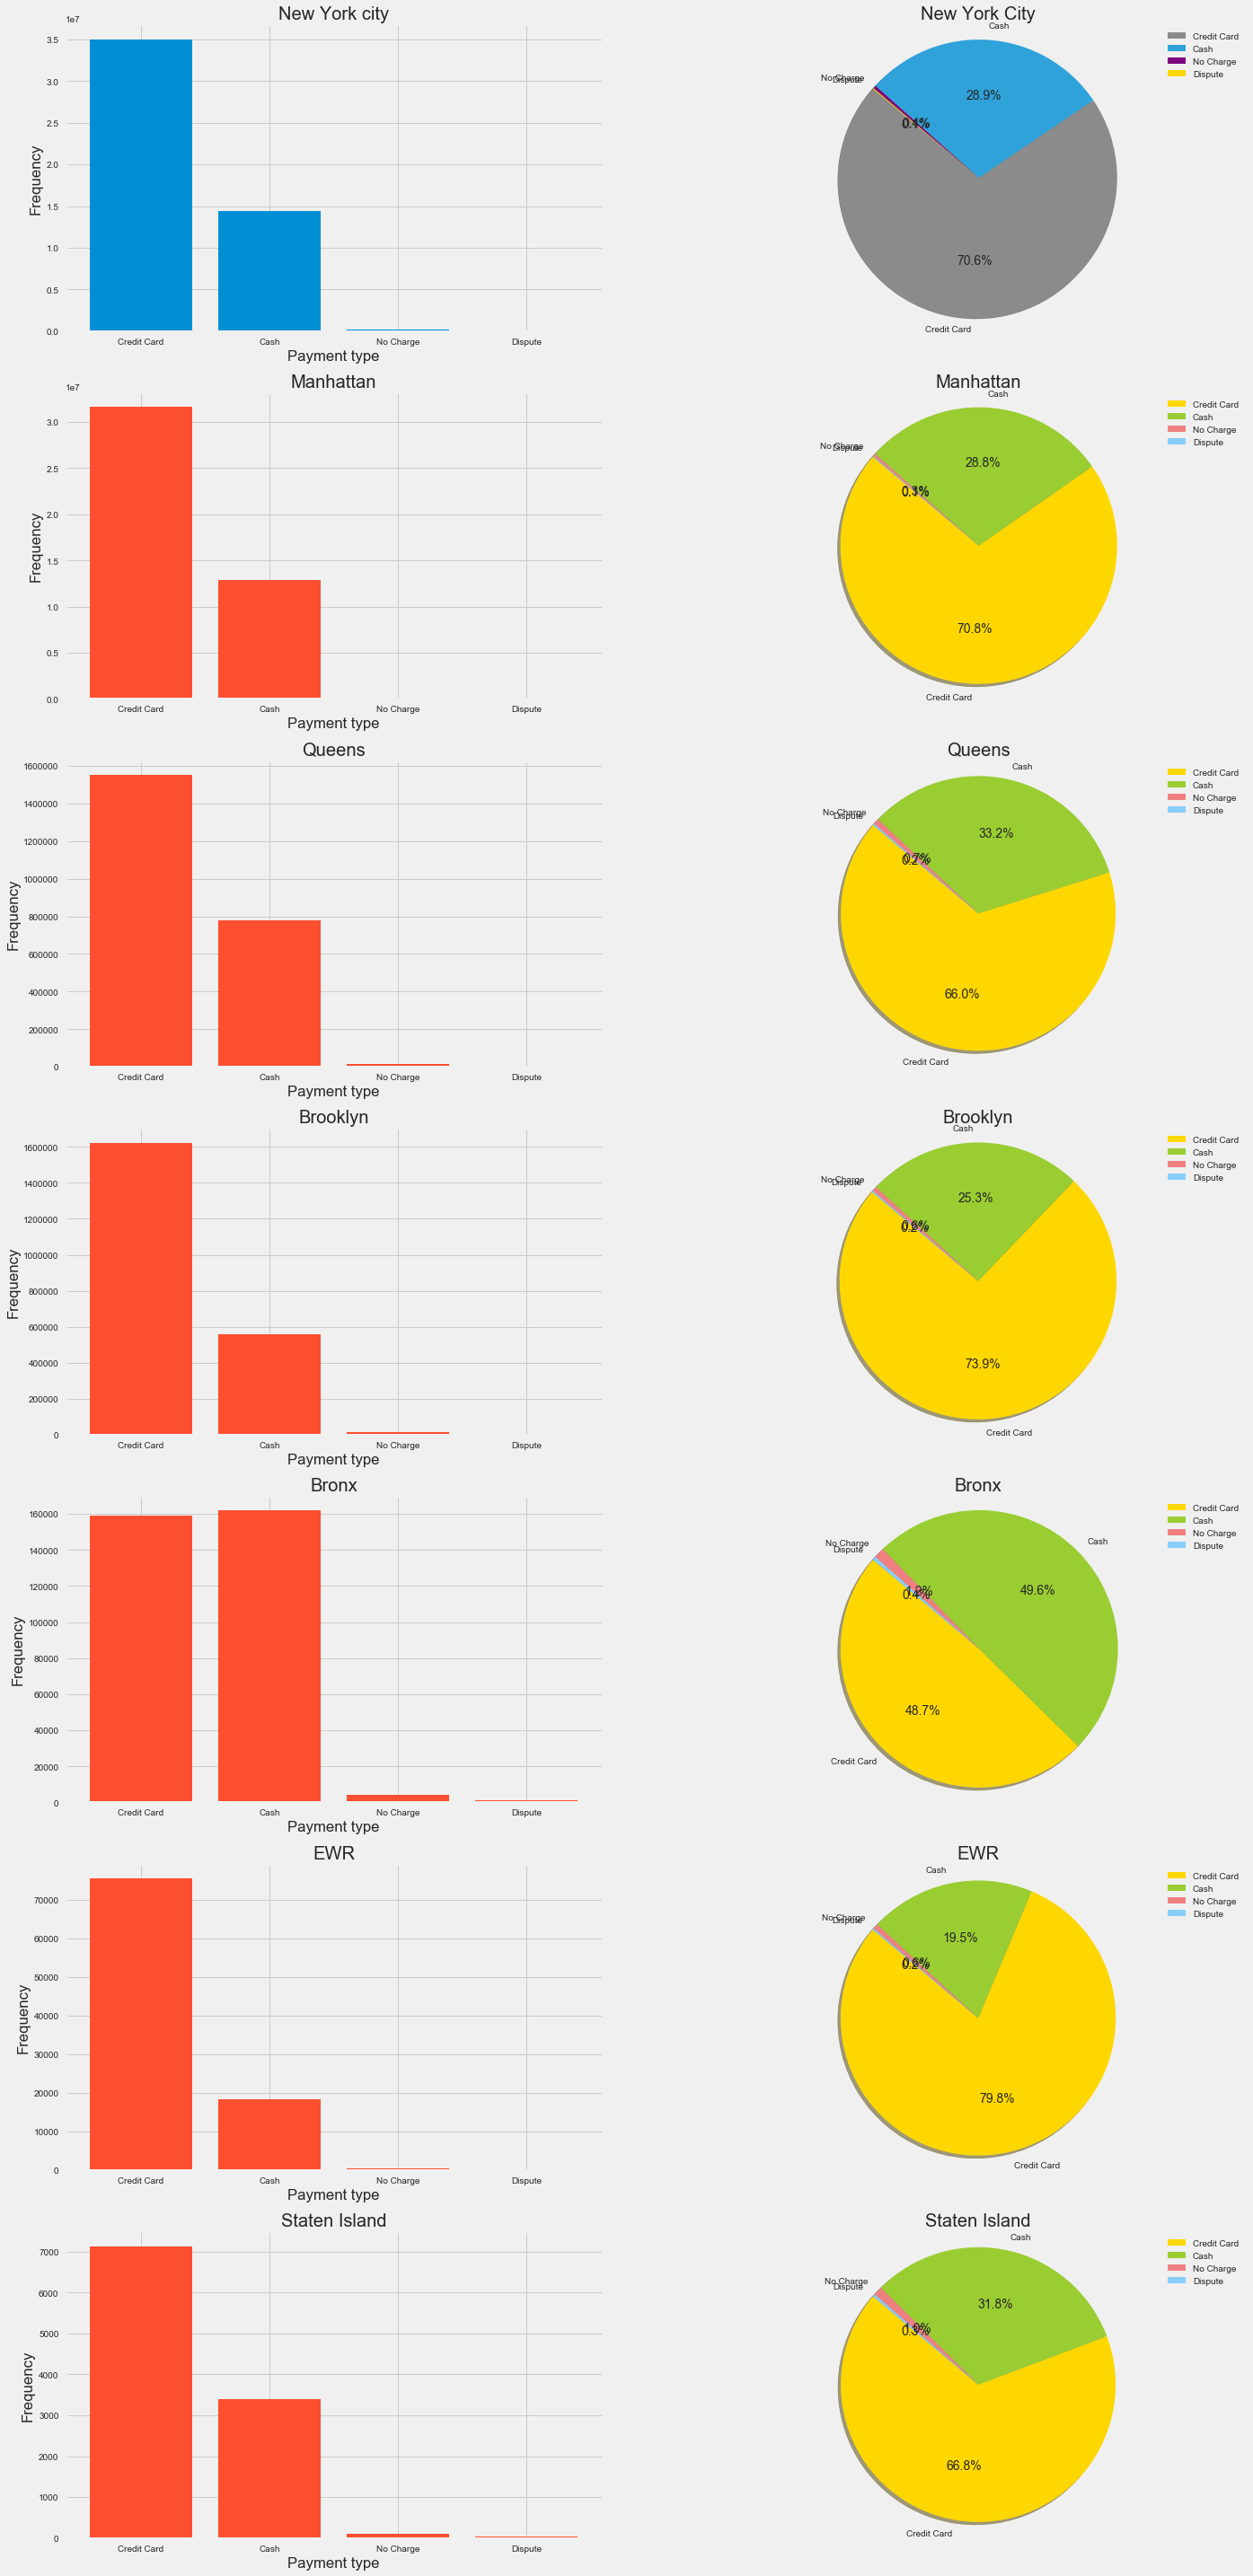

In [6]:
#setting how much each payment type has been used  in each borough(bar plot on the right and bar plot on the left)
length=np.arange(len(payment_types))
f = plt.figure(figsize=(21,48))
f.add_subplot(7,2,1)
#bar-plot
plt.bar(length, ny_payment_type)
plt.xticks(length,["Credit Card","Cash","No Charge","Dispute"])
plt.xlabel("Payment type")
plt.ylabel("Frequency")
plt.title("New York city")
f.add_subplot(7,2,2)
sizes = ny_payment_type
colors = ['#8b8b8b', '#30a2da', 'purple', 'gold']

 
# pie chart
plt.pie(sizes,  
        labels=["Credit Card","Cash","No Charge","Dispute"], 
        colors=colors,
        autopct='%1.1f%%', 
        shadow=True, startangle=140)
 
plt.axis('equal')
plt.title("New York City")
plt.legend(loc="best")


payment_types.sort()
lenght=np.arange(len(payment_types))

i=1
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
for i in range(1,7):
    #loop for displaying how much each payment type has been used in each brough(bar chart left and pie chart right)
    f.add_subplot(7,2,2*i+1)
    plt.bar(lenght, borough_lista[i-1],color="#fc4f30")
    plt.xticks(lenght,["Credit Card","Cash","No Charge","Dispute"])
    plt.xlabel("Payment type")
    plt.ylabel("Frequency")
    plt.title(boroughs[i-1])
    f.add_subplot(7,2,2*i+2)
    labels=payment_types
    sizes=borough_lista[i-1]
    
    plt.pie(sizes, labels=["Credit Card","Cash","No Charge","Dispute"], colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
    plt.title(boroughs[i-1])
    plt.axis('equal')
    plt.legend()
    i+=2
plt.show()

The most common payment type overall is Credit Card, except for Bronx which uses cash and credit card payment in equal amount. This may be because Bronx is a poor neighbourhood relative to the other boroughs. 
The two payment types: Unknown payment and voided payment, were not found in our dataset.

In [8]:
crosstab=pd.crosstab(df['DOBorough'], df['payment_type'])
Chi,p,df,efa=stats.chi2_contingency(crosstab)
Chi,p,dfreedom,efa=stats.chi2_contingency(crosstab)#run Chi-squared test
print("The Chi square value of the test is "+ str(Chi) )
print("The p-value of the test is"+str(p))
print("The degrees of freedom of the test is "+ str(dfreedom))
print("The expected frequecies are:")
print(efa)
del crosstab

The Chi square value of the test is 135365.680383
The p-value of the test is0.0
The degrees of freedom of the test is 15
The expected frequecies are:
[[  2.30382510e+05   9.44625275e+04   1.14920872e+03   3.41753678e+02]
 [  1.55029902e+06   6.35660942e+05   7.73330033e+03   2.29974224e+03]
 [  6.69023931e+04   2.74316359e+04   3.33726780e+02   9.92442476e+01]
 [  3.15199604e+07   1.29239634e+07   1.57229875e+05   4.67572925e+04]
 [  1.66156086e+06   6.81281049e+05   8.28830373e+03   2.46479012e+03]
 [  7.53478786e+03   3.08944939e+03   3.75855089e+01   1.11772437e+01]]


A Chi-squared test was run in order to see wheter the method of payment is correlated to the borough. There were the following two hypothesis:

$H_o$:There is no correlation between the the method of payment and the borough.

$H_1$:There is a correlation between the method of payment and the borough.

The output of the test are a Chi-square value of 134890.582205, a p-value of 0.0(what means that it is very close to 0), 15 degrees of freedom and an array with all the expected frequencies.

All the expected frequencies in the array are bigger than 5, what means that the Chi-square method can be trusted. In addition, the p-value is lower than $5%$, indicating that it is possible to reject the null hypothesis($H_o$) and state that the test support the alternative hypothesis. Therefore, the results indicate that it exists a relationship between the method of payment and the boroughs. This fact might be the case observed before in Bronx where there is a different distribution of payment types.


***[RQ5] Does a long distance correlate with the duration of the trip on average? Make a plot that show the dependence between distance and duration of the trip. Then compute the Pearson Coefficient, is it significant? Comment the results you obtain.***

In [9]:
jan = pd.read_csv("jan_18.csv")
feb = pd.read_csv("feb_18.csv")
mar = pd.read_csv("mar_18.csv")
apr = pd.read_csv("apr_18.csv")
may = pd.read_csv("may_18.csv")
jun = pd.read_csv("jun_18.csv")

dfs = [jan,feb,mar,apr,may,jun]

In [10]:
prsn = pd.DataFrame() 
for df in dfs:
    #filtering unplausible values regarding average speed of the rides - reducing noise
    df = df[df['miles_hour'] <90]
    longdist = df[["trip_distance", "duration"]]
    longdist['minutes'] = longdist['duration'] / 60
    
    prsn = prsn.append(longdist[["minutes","trip_distance"]])

C:\Users\Jose Manuel Camacho\ANACONDA\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


With the help of the scatterplot below we can see that after some meaningful data cleaning/noise removing procedures the relation between duration and distance of rides becomes quite clear.

In [11]:
#we have values with 0 distance or 0 minutes because under some lights they're meaningful. not for the dependacy
#between time and distance. They don't carry information
prsn = prsn[(prsn['minutes']>1) | (prsn['trip_distance']>0)]

In [ ]:
%matplotlib inline

pl = sns.regplot( x=prsn["minutes"], y=prsn["trip_distance"], fit_reg=False, scatter_kws = { 'color': 'darkred', 'alpha':0.06})
pl.set_title("Distance and duration correlation")
pl.set(xlim = (0,210), ylim=(0, 70))

[(0, 70), (0, 210)]

We found a *high* **Pearson coefficient**. This reinforces the fact that space and time are linked to one another, even in traffic. The slow rides are balanced from the fast ones.

In [ ]:
prsn.corr()

In [ ]:
del dfs,jan,feb,mar,apr,may,jun

## Core Research Questions

### Core Research Questions cleaning

In [ ]:
#cleaning for core_question 1
files = ['yellow_tripdata_2018-01.csv', 'yellow_tripdata_2018-02.csv', 'yellow_tripdata_2018-03.csv', 'yellow_tripdata_2018-04.csv', 'yellow_tripdata_2018-05.csv', 'yellow_tripdata_2018-06.csv']
key = ['jan_18_core', 'feb_18_core', 'mar_18_core', 'apr_18_core', 'may_18_core', 'jun_18_core']

borough=pd.read_csv("taxi _zone_lookup.csv")

for i in range(len(files)): 
    ny = pd.read_csv(files[i])

    ny=ny[(ny["PULocationID"]<=263) &(ny["DOLocationID"]<=263)]
    #remove taxis outside the boroughs. Seen on taxis lookup zones db

    ny=ny[ny["fare_amount"]>2.5]
    #removing all amounts lower or equal to 2.5(standard fare)

    ny=ny[ny["trip_distance"]>=0]#no negative distances

    ny=ny[(ny["trip_distance"]>=0) & ((ny["RatecodeID"]==5 )| (ny["PULocationID"]!=ny["DOLocationID"]))]

    ny=ny.join(borough.set_index("LocationID"),on="PULocationID")

    ny=ny.rename(index = str, columns = {"Borough":"PUBorough"})

    ny=ny.drop(['passenger_count','RatecodeID','payment_type','PUBorough','Zone',"service_zone","VendorID","store_and_fwd_flag","extra","mta_tax","tip_amount","tolls_amount","improvement_surcharge","total_amount"],axis=1)

    ny=ny.join(borough.set_index("LocationID"),on="DOLocationID")

    ny=ny.rename(index = str, columns = {"Borough":"DOBorough", 'Zone': 'DOZone'})

    ny=ny.drop(["service_zone"],axis=1)

    ny['tpep_pickup_datetime'] = pd.to_datetime(ny['tpep_pickup_datetime'])
    ny['tpep_dropoff_datetime'] = pd.to_datetime(ny['tpep_dropoff_datetime'])
    
    ny["duration"] = (ny['tpep_dropoff_datetime'] - ny['tpep_pickup_datetime']).astype('timedelta64[s]')
    ny = ny.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)
    
    ny['ppm'] = (ny['fare_amount']/ny['trip_distance']).round(decimals = 2)
    
    ny.to_csv(key[i] + '.csv', mode = 'a', header = True)
    del ny

***[CRQ1]: Does the fare for mile change across NY's borough? We want to discover whether the expenses of a user that enjoys Taxis in one zone is different from those that uses it in another one.***

***The price per mile might depend on traffic the Taxi finds on its way. So we try to mitigate this effect:***

-  ***Likely, the duration of the trip says something about the city's congestion, especially if combined with the distances. It might be a good idea to weight the price for mile using the time $T$ equation needed to complete the trip. Thus, instead of equation, you can use equation $P^{'}=\frac{P}{T}$, where $T$ equation is the time needed to complete the trip.***

- ***Run the mean and the standard deviation of the new variable for each borough. Then plot the distribution. What do you see?***

-  ***Run the t-test among all the possible pairs of new distribution of different boroughs.***

- ***Can you say that statistically significant differences, on the averages, hold among zones? In other words, are Taxis trip in some boroughs, on average, more expensive than others?***

In [ ]:
#function for calculating t-test
def calc_ttest(x, y): 
    x[x==np.inf]=np.nan
    x = x.dropna()

    y[y==np.inf]=np.nan
    y = y.dropna()

    t_test = scipy.stats.ttest_ind(x, y)
    return t_test

#data for 2018 cleaned for core question 2
files = ['jan_18_core.csv', 'feb_18_core.csv', 'mar_18_core.csv', 'apr_18_core.csv', 'may_18_core.csv', 'jun_18_core.csv']

#initialize series to store price per mile value
manhattan = pd.Series()
brooklyn = pd.Series()
bronx = pd.Series()
queens = pd.Series()
ewr = pd.Series()
staten_island = pd.Series()

#loop through all files to read
for i in range(len(files)):     
    x = pd.read_csv(files[i])
    
    # get the price per mile values for each borough. Price per mile was calculated during cleaning for core questions
    manhattan = manhattan.append(x[x['DOBorough'] == 'Manhattan']['ppm'])
    brooklyn = brooklyn.append(x[x['DOBorough'] == 'Bronx']['ppm'])
    bronx = bronx.append(x[x['DOBorough'] == 'Brooklyn']['ppm'])
    queens = queens.append(x[x['DOBorough'] == 'Queens']['ppm'])
    ewr = ewr.append(x[x['DOBorough'] == 'EWR']['ppm'])
    staten_island = staten_island.append(x[x['DOBorough'] == 'Staten Island']['ppm'])
    
    del x

In [ ]:
#set bins for the distribution
bins = []
i = 0
while(i <= 10): 
    bins.append(i)
    i += 0.01

#remove any infinite or NAN values from the series
manhattan[manhattan==np.inf]=np.nan
manhattan = manhattan.dropna()

#calculate and round the mean and standard deviation to 2 decimals
mean = round(manhattan.mean(), 2)
std = round(manhattan.std(), 2)
f = plt.figure(figsize = (25,18))
#plot the histogram
f.add_subplot(2,3,1)
plt.hist(manhattan.values,bins)
plt.tick_params(labelsize = 15)
plt.xlabel('Price per Mile', fontsize = 20)
plt.ylabel('Frequency',fontsize = 20)
plt.title('Manhattan - $\mu='+ str(mean) +'$, $\sigma='+ str(std) +'$', fontsize = 24)
#show the plot
#plt.show()


brooklyn[brooklyn==np.inf]=np.nan
brooklyn = brooklyn.dropna()
mean2 = round(brooklyn.mean(), 2)
std2 = round(brooklyn.std(), 2)
f.add_subplot(2,3,2)
plt.hist(brooklyn.values,bins)
plt.tick_params(labelsize = 15)
plt.xlabel('Price per Mile', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.title('Brooklyn - $\mu='+ str(mean2) +'$, $\sigma='+ str(std2) +'$', fontsize = 24)

f.add_subplot(2,3,3)
bronx[bronx==np.inf]=np.nan
bronx = bronx.dropna()
mean = round(bronx.mean(), 2)
std = round(bronx.std(), 2)
plt.hist(bronx.values,bins)
plt.tick_params(labelsize = 15)
plt.xlabel('Price per Mile', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.title('Bronx - $\mu='+ str(mean) +'$, $\sigma='+ str(std) +'$', fontsize = 24)

f.add_subplot(2,3,4)
queens[queens==np.inf]=np.nan
queens = queens.dropna()
mean = round(queens.mean(), 2)
std = round(queens.std(), 2)
plt.hist(queens.values,bins)
plt.tick_params(labelsize = 15)
plt.xlabel('Price per Mile', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.title('Queens - $\mu='+ str(mean) +'$, $\sigma='+ str(std) +'$', fontsize = 24)

f.add_subplot(2,3,5)
ewr[ewr==np.inf]=np.nan
ewr = ewr.dropna()
mean = round(ewr.mean(), 2)
std = round(ewr.std(), 2)
plt.hist(ewr.values,bins)
plt.tick_params(labelsize = 15)
plt.xlabel('Price per Mile', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.title('EWR - $\mu='+ str(mean) +'$, $\sigma='+ str(std) +'$', fontsize = 24)


f.add_subplot(2,3,6)
staten_island[staten_island==np.inf]=np.nan
staten_island = staten_island.dropna()
mean = round(staten_island.mean(), 2)
std = round(staten_island.std(), 2)
plt.hist(staten_island.values,bins)
plt.tick_params(labelsize = 15)
plt.xlabel('Price per Mile', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.title('Staten Island - $\mu='+ str(mean) +'$, $\sigma='+ str(std) +'$', fontsize = 24)

#show the plot
plt.show()

In [ ]:
#perform t-test for all possible combinations of borough
pvalue_list = []
temp = []

#Manhattan
temp.append('-')
t, p = calc_ttest(manhattan, brooklyn)
temp.append(round(p,4))
t, p = calc_ttest(manhattan, bronx)
temp.append(round(p,4))
t, p = calc_ttest(manhattan, queens)
temp.append(round(p,4))
t, p = calc_ttest(manhattan, ewr)
temp.append(round(p,4))
t, p = calc_ttest(manhattan, staten_island)
temp.append(round(p,4))
pvalue_list.append(temp)

temp = []
t, p = calc_ttest(brooklyn, manhattan)
temp.append(round(p,4))
temp.append('-')
t, p = calc_ttest(brooklyn, bronx)
temp.append(round(p,4))
t, p = calc_ttest(brooklyn, queens)
temp.append(round(p,4))
t, p = calc_ttest(brooklyn, ewr)
temp.append(round(p,4))
t, p = calc_ttest(brooklyn, staten_island)
temp.append(round(p,4))
pvalue_list.append(temp)

temp = []
t, p = calc_ttest(bronx, manhattan)
temp.append(round(p,4))
t, p = calc_ttest(bronx, brooklyn)
temp.append(round(p,4))
temp.append('-')
t, p = calc_ttest(bronx, queens)
temp.append(round(p,4))
t, p = calc_ttest(bronx, ewr)
temp.append(round(p,4))
t, p = calc_ttest(bronx, staten_island)
temp.append(round(p,4))
pvalue_list.append(temp)

temp = []
t, p = calc_ttest(queens, manhattan)
temp.append(round(p,4))
t, p = calc_ttest(queens, brooklyn)
temp.append(round(p,4))
t, p = calc_ttest(queens, bronx)
temp.append(round(p,4))
temp.append('-')
t, p = calc_ttest(queens, ewr)
temp.append(round(p,4))
t, p = calc_ttest(queens, staten_island)
temp.append(round(p,4))
pvalue_list.append(temp)

temp = []
t, p = calc_ttest(ewr, manhattan)
temp.append(round(p,4))
t, p = calc_ttest(ewr, brooklyn)
temp.append(round(p,4))
t, p = calc_ttest(ewr, bronx)
temp.append(round(p,4))
t, p = calc_ttest(ewr, queens)
temp.append(round(p,4))
temp.append('-')
t, p = calc_ttest(ewr, staten_island)
temp.append(round(p,4))
pvalue_list.append(temp)

temp = []
t, p = calc_ttest(staten_island, manhattan)
temp.append(round(p,4))
t, p = calc_ttest(staten_island, brooklyn)
temp.append(round(p,4))
t, p = calc_ttest(staten_island, bronx)
temp.append(round(p,4))
t, p = calc_ttest(staten_island, queens)
temp.append(round(p,4))
t, p = calc_ttest(staten_island, ewr)
temp.append(round(p,4))
temp.append('-')
pvalue_list.append(temp)

pvalue_dataframe = pd.DataFrame(pvalue_list, columns=['Manhattan', 'Brooklyn', 'Bronx', 'Queens', 'EWR', 'Staten Island'], index=['Manhattan', 'Brooklyn', 'Bronx', 'Queens', 'EWR', 'Staten Island'])
print('Table for p-value of price per mile')
pvalue_dataframe

A T-test was run to see if there is a statistically significant difference between each borough. The hypothesis considereded were:

$H_o$:Price per mile on average between boroughs are the same.

$H_1$:Price per mile on average between boroughs are different.

If p-value is less than 0.05 the null hypothesis is rejected, i.e. There is a statistically significant difference between boroughs in price per mile. 

-  Staten Island with respect to other boroughs fails to reject the null hypothesis. Which mean the difference in the price per mile between Staten Island and other boroughs are not statistically significant. 
- The difference in price per mile between all other boroughs (excluding Staten Island) reject the null hypothesis. Which means the difference in price per mile between the boroughs (excluding Staten Island) are statistically significant. 

### Weighted price per mile
In addition to comparingn price per mile for each borough, a weighted price per mile $(P')$ is calculated:$P/T$. 

***P = Price per Mile***

***T = Duration of the trip in miutes***

This was done to see if the price per mile is affected by traffic.



In [ ]:
#initialize series to place p' or the weighted price per mile
manhattan_weighted = pd.Series()
brooklyn_weighted = pd.Series()
bronx_weighted = pd.Series()
queens_weighted = pd.Series()
ewr_weighted = pd.Series()
staten_island_weighted = pd.Series()

#loop through to read all files
for i in range(len(files)): 
    x = pd.read_csv(files[i])           
    
    #calculate weighed price per mile by dividing the price per mile by Time(minutes)
    x['p'] = x['ppm']/(x['duration']/60)
    
    #assign weighted price per mile value to each series by borough
    manhattan_weighted = manhattan_weighted.append(x[x['DOBorough'] == 'Manhattan']['p'])
    brooklyn_weighted = brooklyn_weighted.append(x[x['DOBorough'] == 'Bronx']['p'])
    bronx_weighted = bronx_weighted.append(x[x['DOBorough'] == 'Brooklyn']['p'])
    queens_weighted = queens_weighted.append(x[x['DOBorough'] == 'Queens']['p'])
    ewr_weighted = ewr_weighted.append(x[x['DOBorough'] == 'EWR']['p'])
    staten_island_weighted = staten_island_weighted.append(x[x['DOBorough'] == 'Staten Island']['p'])
    del x

In [ ]:
#set up bins for the histogram distribution 
bins = []
i = 0
while(i <= 10): 
    bins.append(i)
    i += 0.1
#drop all infinte values and NAN values
f = plt.figure(figsize = (27,16))
manhattan_weighted[manhattan_weighted==np.inf]=np.nan
manhattan_weighted = manhattan_weighted.dropna()
#calculate mean and standard dev
mean = round(manhattan_weighted.mean(), 2)
std = round(manhattan_weighted.std(), 2)
f.add_subplot(2,3,1)
plt.hist(manhattan_weighted.values, bins)
plt.tick_params(labelsize=15)
plt.xlabel('Weighted Price per mile', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.title('Manhattan - $\mu='+ str(mean) +'$, $\sigma='+ str(std) +'$', fontsize = 20)

brooklyn_weighted[brooklyn_weighted==np.inf]=np.nan
brooklyn_weighted = brooklyn_weighted.dropna()
mean = round(brooklyn_weighted.mean(), 2)
std = round(brooklyn_weighted.std(), 2)
f.add_subplot(2,3,2)
plt.hist(brooklyn_weighted.values, bins)
plt.tick_params(labelsize = 15)
plt.xlabel('Weighted Price per mile', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.title('Brooklyn - $\mu='+ str(mean) +'$, $\sigma='+ str(std) +'$' , fontsize = 21)

bronx_weighted[bronx_weighted==np.inf]=np.nan
bronx_weighted = bronx_weighted.dropna()
mean = round(bronx_weighted.mean(), 2)
std = round(bronx_weighted.std(), 2)
f.add_subplot(2,3,3)
plt.hist(bronx_weighted.values, bins)
plt.tick_params(labelsize = 15)
plt.xlabel('Weighted Price per mile', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.title('Bronx - $\mu='+ str(mean) +'$, $\sigma='+ str(std) +'$', fontsize = 21)

queens_weighted[queens_weighted==np.inf]=np.nan
queens_weighted = queens_weighted.dropna()
mean = round(queens_weighted.mean(), 2)
std = round(queens_weighted.std(), 2)
f.add_subplot(2,3,4)
plt.hist(queens_weighted.values, bins)
plt.tick_params(labelsize = 15)
plt.xlabel('Weighted Price per mile', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.title('Queens - $\mu='+ str(mean) +'$, $\sigma='+ str(std) +'$', fontsize = 21)

ewr_weighted[ewr_weighted==np.inf]=np.nan
ewr_weighted = ewr_weighted.dropna()
mean = round(ewr_weighted.mean(), 2)
std = round(ewr_weighted.std(), 2)
f.add_subplot(2,3,5)
plt.hist(ewr_weighted.values, bins)
plt.tick_params(labelsize = 15)
plt.xlabel('Weighted Price per mile', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.title('EWR - $\mu='+ str(mean) +'$, $\sigma='+ str(std) +'$', fontsize = 21)

staten_island_weighted[staten_island_weighted==np.inf]=np.nan
staten_island_weighted = staten_island_weighted.dropna()
mean = round(staten_island_weighted.mean(), 2)
std = round(staten_island_weighted.std(), 2)
f.add_subplot(2,3,6)
plt.hist(staten_island_weighted.values, bins)
plt.tick_params(labelsize = 15)
plt.xlabel('Weighted Price per mile', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.title('Staten Island - $\mu='+ str(mean) +'$, $\sigma='+ str(std) +'$', fontsize = 21)
plt.show()

In [ ]:
#perform t-test for all possible combinations of borough
pvalue_list = []
temp = []

#Manhattan
temp.append('-')
t, p = calc_ttest(manhattan_weighted, brooklyn_weighted)
temp.append(round(p,4))
t, p = calc_ttest(manhattan_weighted, bronx_weighted)
temp.append(round(p,4))
t, p = calc_ttest(manhattan_weighted, queens_weighted)
temp.append(round(p,4))
t, p = calc_ttest(manhattan_weighted, ewr_weighted)
temp.append(round(p,4))
t, p = calc_ttest(manhattan_weighted, staten_island_weighted)
temp.append(round(p,4))
pvalue_list.append(temp)

temp = []
t, p = calc_ttest(brooklyn_weighted, manhattan_weighted)
temp.append(round(p,4))
temp.append('-')
t, p = calc_ttest(brooklyn_weighted, bronx_weighted)
temp.append(round(p,4))
t, p = calc_ttest(brooklyn_weighted, queens_weighted)
temp.append(round(p,4))
t, p = calc_ttest(brooklyn_weighted, ewr_weighted)
temp.append(round(p,4))
t, p = calc_ttest(brooklyn_weighted, staten_island_weighted)
temp.append(round(p,4))
pvalue_list.append(temp)

temp = []
t, p = calc_ttest(bronx_weighted, manhattan_weighted)
temp.append(round(p,4))
t, p = calc_ttest(bronx_weighted, brooklyn_weighted)
temp.append(round(p,4))
temp.append('-')
t, p = calc_ttest(bronx_weighted, queens_weighted)
temp.append(round(p,4))
t, p = calc_ttest(bronx_weighted, ewr_weighted)
temp.append(round(p,4))
t, p = calc_ttest(bronx_weighted, staten_island_weighted)
temp.append(round(p,4))
pvalue_list.append(temp)

temp = []
t, p = calc_ttest(queens_weighted, manhattan_weighted)
temp.append(round(p,4))
t, p = calc_ttest(queens_weighted, brooklyn_weighted)
temp.append(round(p,4))
t, p = calc_ttest(queens_weighted, bronx_weighted)
temp.append(round(p,4))
temp.append('-')
t, p = calc_ttest(queens_weighted, ewr_weighted)
temp.append(round(p,4))
t, p = calc_ttest(queens_weighted, staten_island_weighted)
temp.append(round(p,4))
pvalue_list.append(temp)

temp = []
t, p = calc_ttest(ewr_weighted, manhattan_weighted)
temp.append(round(p,4))
t, p = calc_ttest(ewr_weighted, brooklyn_weighted)
temp.append(round(p,4))
t, p = calc_ttest(ewr_weighted, bronx_weighted)
temp.append(round(p,4))
t, p = calc_ttest(ewr_weighted, queens_weighted)
temp.append(round(p,4))
temp.append('-')
t, p = calc_ttest(ewr_weighted, staten_island_weighted)
temp.append(round(p,4))
pvalue_list.append(temp)

temp = []
t, p = calc_ttest(staten_island_weighted, manhattan_weighted)
temp.append(round(p,4))
t, p = calc_ttest(staten_island_weighted, brooklyn_weighted)
temp.append(round(p,4))
t, p = calc_ttest(staten_island_weighted, bronx_weighted)
temp.append(round(p,4))
t, p = calc_ttest(staten_island_weighted, queens_weighted)
temp.append(round(p,4))
t, p = calc_ttest(staten_island_weighted, ewr_weighted)
temp.append(round(p,4))
temp.append('-')
pvalue_list.append(temp)

pvalue_dataframe = pd.DataFrame(pvalue_list, columns=['Manhattan', 'Brooklyn', 'Bronx', 'Queens', 'EWR', 'Staten Island'], index=['Manhattan', 'Brooklyn', 'Bronx', 'Queens', 'EWR', 'Staten Island'])
print('Table for p-value of weighted price per mile')
pvalue_dataframe


A T-test was run to see if there is a statistically significant difference between each borough. 

$H_o$:Price per mile on average between boroughs are the same.

$H_1$:Price per mile on average between boroughs are different.


If p-value is less than 0.05 the null hypothesis is rejected, i.e. There is a statistically significant difference between boroughs in price per mile. 

-  Staten Island with respect to other boroughs fails to reject the null hypothesis. Which mean the difference in the price per mile between Staten Island and other boroughs are not statistically significant. 
-  Ttest for Brooklynn and Manhattan fails to reject the null hypothesis. Which mean the difference in the price per mile between Staten Island and other boroughs are not statistically significant. 
- The difference in price per mile between all other boroughs (excluding Staten Island with respect to all boroughs and Manhattan with brooklyn) reject the null hypothesis. Which means the difference in price per mile between the boroughs are statistically significant. 

***[CRQ2]: Visualize Taxis movements!***

In [ ]:
jan_core = pd.read_csv("jan_18_core.csv")
feb_core = pd.read_csv("feb_18_core.csv")
mar_core = pd.read_csv("mar_18_core.csv")
apr_core = pd.read_csv("apr_18_core.csv")
may_core = pd.read_csv("may_18_core.csv")
jun_core = pd.read_csv("jun_18_core.csv")


In [ ]:
frames = [jan_core, feb_core, mar_core, apr_core, may_core, jun_core]

In [ ]:
#we create a new empty dataframe, and then we add all the LocationIDs 
viz = pd.DataFrame() 
for df in frames:
    viz = viz.append(df[["PULocationID","DOLocationID"]])

In [ ]:
#we create a column 'counts' with the number of rides in each Location
vizPU = viz.groupby(['PULocationID']).size().reset_index(name='counts')

#appending missing values to the Pick Up df, because they were not in out data since there are not rides in those zones
vizPU = vizPU.append({'PULocationID' : 103 , 'counts' : 0} , ignore_index=True)
vizPU = vizPU.append({'PULocationID' : 104 , 'counts' : 0} , ignore_index=True)
vizPU = vizPU.append({'PULocationID' : 99 , 'counts' : 0} , ignore_index=True)

In [ ]:
#loading the json file with the coordinates of nyc zones
geo_json = json.load(open('taxi_zones.json'))

In [ ]:
#PICK UP LOCATION MAP

m = folium.Map(location=[40.7, -74], zoom_start = 10.5)
folium.GeoJson(geo_json).add_to(m) #adding the coordinates given by the json file

#creating the choroplet map and setting parameters
m.choropleth(
    geo_data= geo_json,
    name= 'choropleth',
    data = vizPU,
    columns = ['PULocationID', 'counts'],
    key_on = 'feature.properties.LocationID',
    fill_color = 'BuPu',
    fill_opacity = 0.5,
    line_opacity = 0.3,
    legend_name = "Taxi pick up locations map"
 
)

In [ ]:
m

We can see through this choroplet map that the zones more frequented by yellow taxis are in the heart of Manhattan, specially in the adjacency of Central Park : Upper East Side (Park Avenue), Midtown and in proximity of Penn Station (main intercity railroad station in NYC). The yellow cab usage is also high in the area under central park - between 3rd and 9th Avenues (Times Square - Diamond District - other points of interest). Easy to say that these locations are really crowded and even highly populated by tourists, all zones in which the flow of people is high.

Regarding the whole map Manhattan is competing in a different league in relation to other boroughs, "owning" the great majority of taxi rides. The lower level of Pick ups in the northern part of Manhattan could be due to the fact that Green Taxis are allowed to start rides there (north of West 110th street and East 96th street) and in all other boroughs, and they can drop the passengers off anywhere, those data obviously are not considered in our analysis. We can also see that the only other darker areas outside Manhattan are two airports: JFK and La Guardia (both in Queens) respectively first and third airports for traffic in New York City. The second - Newark Airport - is served mainly by New Jersey's local companies of taxis, so it does not have a significant spot in our yellow cabs map.

In [ ]:
#we create a column 'counts' with the number of rides in each Location
vizDO = viz.groupby(['DOLocationID']).size().reset_index(name='counts')

In [ ]:
#appending missing values to the Drop Off df, so the map won't show wrong things
vizDO = vizDO.append({'DOLocationID' : 103 , 'counts' : 0} , ignore_index=True)
vizDO = vizDO.append({'DOLocationID' : 104 , 'counts' : 0} , ignore_index=True)
vizDO = vizDO.append({'DOLocationID' : 110 , 'counts' : 0} , ignore_index=True)

In [ ]:
#DROP OFF LOCATION MAP

l = folium.Map(location=[40.7, -74], zoom_start = 10.5)
folium.GeoJson(geo_json).add_to(l) #adding the coordinates given by the json file


#creating the choroplet map and setting parameters
l.choropleth(
    geo_data= geo_json,
    name= 'choropleth',
    data = vizDO,
    columns = ['DOLocationID', 'counts'],
    key_on = 'feature.properties.LocationID',
    fill_color = 'BuPu',
    fill_opacity = 0.5,
    line_opacity = 0.3,
    legend_name = "Taxi drop off locations map"
 
)

Looking at the drop off map _we can't say anything different_ from the previous choroplet (pick ups), this is probably caused by the __balanced process of rides starting and ending in the same places__; in the sense that there are not significative reasons to have flows just in one way in the most popular zones.

In [ ]:
l